# Footprint Overlap Detector for Spacecraft Field-of-View (FoV) Sensors (nadir orientation)

A detector is triggered when a spacecraft's sensor enters or exits a specific geographical region within its Field of View (FoV). This detector combines features from both the FieldOfViewDetector and GeographicZoneDetector. Similar to the first detector, it activates upon entry or exit of targets in the FoV, factoring in the spacecraft’s attitude.

The sensor's FoV can be defined in several ways:

- Circular FoV – A simple circular area around the sensor.
- Rectangular FoV – A rectangular area offering directional coverage.
- Half Power Beam Width (HPBW) FoV – A field of view based on the sensor's HPBW, typically used in antenna beam modeling.

The spacecraft's attitude is aligned in a **nadir** orientation.

The FootprintOverlapDetector is compatible with any custom shapes. However, when defining coordinates for the area of interest, the input coordinates must be arranged consecutively in a counterclockwise direction.r.

In [3]:
import orekit
vm = orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

from org.orekit.attitudes import NadirPointing
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.frames import FramesFactory
from org.orekit.time import TimeScalesFactory, AbsoluteDate
from org.orekit.utils import Constants, IERSConventions, PVCoordinatesProvider
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from org.orekit.models.earth.tessellation import EllipsoidTessellator
from org.orekit.propagation.events import EventDetector, EventsLogger, FootprintOverlapDetector
from org.orekit.propagation.events.handlers import ContinueOnEvent, StopOnEvent
from org.orekit.geometry.fov import DoubleDihedraFieldOfView, CircularFieldOfView
from org.hipparchus.geometry.euclidean.threed import Vector3D, Line
from org.hipparchus.geometry.spherical.twod import SphericalPolygonsSet

from math import radians, degrees, pi, sqrt, atan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

First call the frames and time scales to be used in the code and create Earth body.

In [5]:
UTC = TimeScalesFactory.getUTC()                               # Define UTC time scale.
ECI = FramesFactory.getEME2000()                               # Define ECI reference frame.
ECEF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)  # Define ECEF reference frame.
TEME = FramesFactory.getTEME()                                 # Define TEME reference frame. 
ITRF = ECEF

R_earth  = Constants.WGS84_EARTH_EQUATORIAL_RADIUS             # Radius of earth
Mu_earth = Constants.WGS84_EARTH_MU                            # Gravitational parameter of earth
f_earth  = Constants.WGS84_EARTH_FLATTENING                    # Earth flattening value

earth = OneAxisEllipsoid(R_earth, f_earth, ITRF)               # Create earth here.

Here, we first take TLE as an input, and from the TLEPropagator we recieve its PV to get Kepler Elements.

In [7]:
# ISS 25544
tle_line1 = "1 25544U 98067A   24265.15389185  .00020992  00000-0  38244-3 0  9995"
tle_line2 = "2 25544  51.6375 200.0394 0007352  15.0244 345.0962 15.49404240473433"
mytle = TLE(tle_line1, tle_line2)

initialDate = mytle.getDate()                   # This is the TLE epoch date read from first line.
finalDate = initialDate.shiftedBy(3600.0 * 72)   # Shift initial date by x hours.

print('Propagation initial date: ', initialDate)
print('Propagation final date: ', finalDate)

satellite_mass = 466615.0                        # Satellite mass [kg]
attitudeProvider = NadirPointing(TEME, earth)    # Also provide attitude of the satellite

SGP4 = TLEPropagator.selectExtrapolator(mytle, attitudeProvider, satellite_mass) 

Propagation initial date:  2024-09-21T03:41:36.25584Z
Propagation final date:  2024-09-24T03:41:36.25584Z


In the following parts, we are going to create a custom zone from lat/long coordinates.

### Creating the Region-of-Interest

If user wants to define custom coordinates, this cell can be used.

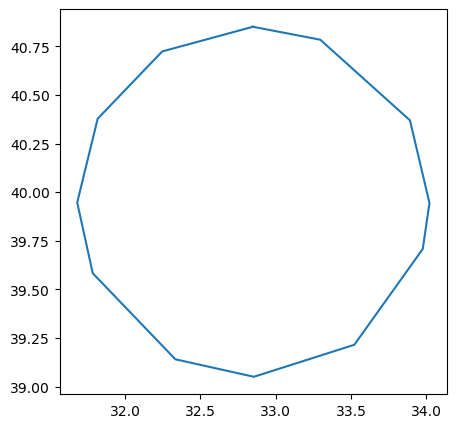

In [11]:
##### User can choose any coordinates he/she wants. 
# Circular zone
zone = [(40.85067, 32.84835), (40.72374, 32.24578), (40.37779, 31.81747), (39.94692, 31.68155),
        (39.58290, 31.78467), (39.14025, 32.33309), (39.05024, 32.85494), (39.21487, 33.52164),
        (39.70781, 33.97609), (39.94393, 34.02072), (40.36942, 33.89107), (40.78416, 33.29552),
        (40.85067, 32.84835)]

geodeticPoints2 = []
for lat2, lon2 in zone:
    geodeticPoints2.append(GeodeticPoint(radians(lat2), radians(lon2), 0.0))


hyperplaneThickness = 1.0e-10

region_polygon2 = EllipsoidTessellator.buildSimpleZone(hyperplaneThickness, geodeticPoints2)

zone = list(zone)
lat2 = [x for x,y in zone]
lon2 = [y for x,y in zone]
lat2 = np.array(lat2)

# Plotting the region-of-interest
fig = plt.figure("zone")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.figure(1)
plt.plot((lon2),(lat2))
plt.show()

## Creating the Spacecraft FoV Sensor

This function provides flexibility in creating different types of sensor field-of-view (FoV) models, each tailored to specific sensor configurations and mission requirements:

- Circular FoV: Ideal for general coverage around the sensor.
- Rectangular FoV: Suitable for directional coverage.
- HPBW FoV: Typically used in antenna systems, taking into account frequency and sensor size.
 
This enhances the versatility of satellite tracking and detection simulations based on user-defined sensor configurations.

In [14]:
# Function to create Field-Of-View based on user input
def create_fov():
    print("Choose the type of Ground Field of View (FoV):")
    print("1- Circular FoV")
    print("2- Rectangular FoV")
    print("3- Half Power Beam Width (HPBW) FoV")

    fov_choice = input("Enter your choice (1/2/3): ")

    if fov_choice == "1":
        # Circular Field-Of-View
        circular_fov = input("Enter the half-angle of the circular FoV (degrees): ")
        circular_fov = float(circular_fov)
        fov_margin = 0.0
        imagerFOV = CircularFieldOfView(Vector3D.PLUS_K, radians(circular_fov), fov_margin)
        print("Circular FoV created.")

        
    elif fov_choice == "2":
        # Rectangular Field-Of-View
        verticalfov  = input('Enter the vertical half-angle (in degrees) of the cone formed by the target and the ground detector: ')
        verticalfov  = float(verticalfov)
        horizontalfov  = input('Enter the horizontal half-angle (in degrees) of the cone formed by the target and the ground detector: ')
        horizontalfov  = float(horizontalfov)
        fov_margin = 0.0

        # Create the Rectangular Field-Of-View
        imagerFOV = DoubleDihedraFieldOfView(Vector3D.PLUS_K,             # center
                                             Vector3D.PLUS_I,             # axis1
                                             radians(verticalfov),   # halfAperture1
                                             Vector3D.PLUS_J,             # axis2
                                             radians(horizontalfov), # halfAperture2
                                             fov_margin)                  # margin
        print("Rectangular FoV created.")
        
    elif fov_choice == "3":
        frequency = input('Enter the frequency of s/c in GHz:  ')
        frequency = float(frequency)
        diameter = input('Enter the diameter of the sensor in meters:  ')
        diameter = float(diameter)

        half_angle = ((70*0.3)/(frequency*diameter))/2
        xfov = half_angle
        fov_margin = 0.0

        imagerFOV = CircularFieldOfView(Vector3D.PLUS_K, radians(xfov), fov_margin)
        print("HPBW FoV created.")

    else:
        print("Invalid choice. Please select a valid option.")
        return create_fov()  # Recursion to prompt the user again if invalid input is given.

    return imagerFOV

# Call the function to create the appropriate Field-Of-View based on user input
imagerFOV = create_fov()

Choose the type of Ground Field of View (FoV):
1- Circular FoV
2- Rectangular FoV
3- Half Power Beam Width (HPBW) FoV


Enter your choice (1/2/3):  1
Enter the half-angle of the circular FoV (degrees):  30


Circular FoV created.


In [15]:
sampling_step = 1000.0
 
# Define FootprintOverlapDetector and add it to the propagator
FPODetector = FootprintOverlapDetector(imagerFOV, earth, 
                                        region_polygon2, 
                                        sampling_step).withHandler(ContinueOnEvent())
# Get the logger for events.
FPO_logger = EventsLogger()

# Add the detector to the SGP4 propagator
SGP4.addEventDetector(FPO_logger.monitorDetector(FPODetector))

Now start propagating the TLE with SGP4. Here, propagation interval has to be sufficiently small because if it is large, detectors may miss certain events.

In [17]:
pos = []                                                       # position vector array to be filled.
SGP4 = PVCoordinatesProvider.cast_(SGP4)
###Start SGP4 propagation from initialDate up until finalDate
while (initialDate.compareTo(finalDate) <= 0.0):
    SGP4_pv = SGP4.getPVCoordinates(initialDate, ITRF)         # Get PV coordinates
    posSGP4 = SGP4_pv.getPosition()                            # But we only want position vector.
    pos.append((posSGP4.getX(),posSGP4.getY(),posSGP4.getZ())) # Get individual elements of position
    posSGP4 = pos
    initialDate = initialDate.shiftedBy(10.0)                  # Propagate with 10 sec intervals.

Finally the logged events are retrieved and printed in a readable way.

In [29]:
FPO_events = FPO_logger.getLoggedEvents()            

entry_list = []
exit_list = []
duration_list = []


for event in FPO_events: 
    if not event.isIncreasing():
        fpo_entry = event.getState().getDate()
        entry_str = str(fpo_entry).replace("T", " ==> ")
        entry_list.append(entry_str)
    else:
        fpo_exit = event.getState().getDate()
        exit_str = str(fpo_exit).replace("T", " ==> ")
        exit_list.append(exit_str)

        fpo_duration = fpo_exit.durationFrom(fpo_entry) / 60  # Convert to minutes
        duration_list.append(fpo_duration)

# Create the DataFrame
df_fpo = pd.DataFrame({
    'FPO Entry': entry_list,
    'FPO Exit': exit_list,
    'Duration (min)': duration_list
})

# Display the DataFrame
display(df_fpo)

,FPO Entry,FPO Exit,Duration (min)
0,2024-09-21 ==> 19:41:11.82761809454885Z,2024-09-21 ==> 19:42:07.09510091506427Z,0.921125
1,2024-09-23 ==> 13:12:07.35186319241265Z,2024-09-23 ==> 13:13:24.03209857140225Z,1.278004
2,2024-09-23 ==> 19:42:18.17181102465612Z,2024-09-23 ==> 19:42:56.70862953374825Z,0.642280
